# The Baseball Futures Market

### Introduction

   As the Supreme Court nears its decision on the latest sports gambling case, the nation may be looking at new and robust market. Gambling in the United States may soon shed its notorious ambiguity, opening the door for newly-legitimized work in data science. Daily fantasy, which users pay money to participate in a predictions and win money for correct picks (gambling in any reasonable interpretation of the word), is constantly advertised and in fact promoted by the major sports leagues through lucrative sponsorship deals, sending a majority of payouts to the top five percent of players.
   
   Getting gambling away from the draconian tactics of Las Vegas casinos will only open the market to fairer play and lower the barrier to (legal) entry into the industry. Black market gambling is a multi-billion-dollar space, filled with die-hard and delusional fans without the ability to use data science as an informative tool in their investments. And unlike legitimate futures markets that trade commodities and financial products, teams will actually be punished for fixing games.

### Who Might Care

The average fan knows nearly nothing about predicting game outcomes. The problems associated with a twenty-four hour news cycle are not lost on sports--talk radio personalities drive a narrative and television hosts have a panel of nonsense every night. Sports, in other words, has the same potential for misinformation and therefore the same potential for exploiting inefficiencies. 

Much like financial markets, sporting event outcomes are priced for their likelihood. If your team can’t win, maybe you can pick players and teams that will perform. So, this project is for the disgruntled fan, sick of waiting around for Midas to grace their team with a touch of gold, who instead wants to become a part of the entertainment, forgetting what they cannot control and instead focusing on what they can. There are already some great sites that provide apps and newsletters for the amateur gambler. It's a growing space that reaches out directly to the consumer and has an unknown (untested) ceiling.

This project's ambitious aim is to illuminate what can accurately predict the winner of a game, hopefully, parsing out the signal from the noise.

### Data Wrangling

A lot of what holds sports analytics back is inaccessible data. It’s difficult to get your hands on and it’s prohibitively expensive to the average fan, but fundamental to how sports organizations view their business. Stattleship API gives community access to Sports Radar data for a small donation every month. This eliminates a huge barrier that casuals face in analyzing sports data. They host a wealth of data on team performance and individual stats available in almost infinite combinations. So for most sports, this a great way to go.

However, any baseball analysis leads back to one main source: Retrosheet. It's a comprehensive community efforts spearheaded and supported by baseball statisticians inspired by the Moneyball revolution started by Bill James's sabermetrics approach. Bill James remains the Hadley Wickham of baseball data, the Guido von Rossum of understanding the sport: perpetually present and forward-looking, inescapable, King James the All-Seeing.

I was able to obtain historical odds for baseball games going back to 2009, so this analysis will focus on the last nine years of regular season baseball. After connecting the two data sources, I'll have summarized information leading up to the game, the game results, and the cost to wager on an outcome.

Retrosheet event files are in a unique format, but luckily there are a lot of resources that explain how to gather and process the data into CSV files. After some frustrating hours, I was able to compile data going back to 2009, though the same level of information is available going back to the 1950's.

I separated out performance into three areas--starting pitching, bullpen pitching, and batting--for the home and away teams. I recreated some popular and predictive sabermetric statistics and some general summaries, rolled up in season averages and averages for the last five and ten games respectively. In this way, I'll be able to see career data for pitchers and seasonal data for the bullpen and offense and do a comparison to see over-and-under performance relative to their average performace. Do each of these units regress towards the mean? Or do they trend in some direction? 

Each game has calculations comparing the average of the starting pitchers and bullpen of one team with the offense of the other. The most promising as I see it: Pythagorean Win Expectation; flyball-to-home run ratio; line drive rate; Batting Average on Balls in Play (BABIP); strikeout-to-walk ratio; Weighted on Base Average (wOBA). 

The odds data has the starting and ending prices for an outcome including a win and over/under a given number of runs (usually six or seven). In addition to the price, it includes the outcome for bet, giving me a series of categories to perform a logistic regression on. 

The interesting dynamic offered in this exercise is the ability to change the amount wagered based on a confidence level. Given my performance columns, how confident am I that the Astros will beat the Dodgers? That confidence level--calculated through a linear regression--can inform my bet amount and inject some excitement in how I play the market.

If I wanted to take this a step further, I could wrangle some Pitch F/X data, which tracks each pitch, its location, type, the result of the at bat, and a hit location if applicable. From this, I could find out if a batting lineup struggles with sliders and predict how they would perform against a starting pitcher that dominates with one. For now, however, I'll stick to Retrosheet and search for indicators in more general summaries.

## Data Storytelling

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

#### Final Dataset
The following is the final data set in preparation for the Machine Learning portion of the project. It was compiled using the notebook entitled: Game & Odds Compilation.

In [2]:
bball = pd.read_csv(r'C:\\Users\\mendo\\Desktop\\final_game_info.csv', sep=',',low_memory=False,  header=0, index_col=0)
bball = bball[bball['home_games_played'] >= 30]
bball.head()

,game_id,odds_matchup,date,weekday,season,month,start_time,duration,total_innings,day_night,game_site,attendance,home_final,vis_final,dh_used,home_team,visiting_team_x,home_plate_ump,base1_ump,base2_ump,base3_ump,temperature,wind_dir,wind_speed,field_cond,precipitation,sky,home_starting_pitcher,vis_starting_pitcher,winning_pitcher,losing_pitcher,save,home_hits,vis_hits,home_errors,vis_errors,home_lob,vis_lob,winner,home_minus_1,home_plus_1,away_minus_1,away_plus_1,ou_6,ou_7,ou_8,ou_9,p_ml_home_start,p_ml_away_start,p_ml_home_final,p_ml_away_final,wager,winning_team,losing_team,winning_runs,losing_runs,ml_h_win,ml_a_win,h_ml_result,v_ml_result,home_team_x,visiting_team_y,home_win_c,home_loss_c,vis_win_c,vis_loss_c,home_p_win_percentage_x,vis_p_win_percentage_x,home_x_wins,vis_x_wins,home_x_win_diff,vis_x_win_diff,home_r_wins,home_r_losses,home_r_runs_scored,home_r_runs_allowed,home_games,home_games_played,home_win_percentage,home_p_win_percentage_y,home_expected_wins,home_expected_losses,home_win_difference,vis_r_wins,vis_r_losses,vis_r_runs_scored,vis_r_runs_allowed,vis_games,vis_games_played,vis_win_percentage,vis_p_win_percentage_y,vis_expected_wins,vis_expected_losses,vis_win_difference,home_s_pitcher,home_s_pitcher_hand,vis_s_pitcher,vis_s_pitcher_hand,m_ldr_def,m_ldr_off,m_gbr_def,m_gbr_off,m_hrfb_def,m_xFIP_def,m_xFIP_off,m_wOBA_def,m_wOBA_off,m_BABIP_def,m_BABIP_off,m_kbr_def,m_kbr_off,m_ldr_def_5,m_ldr_off_5,m_gbr_def_5,m_gbr_off_5,m_hrfb_def_5,m_xFIP_def_5,m_xFIP_off_5,m_wOBA_def_5,m_wOBA_off_5,m_BABIP_def_5,m_BABIP_off_5,m_kbr_def_5,m_kbr_off_5,m_ldr_def_10,m_ldr_off_10,m_gbr_def_10,m_gbr_off_10,m_hrfb_def_10,m_xFIP_def_10,m_xFIP_off_10,m_wOBA_def_10,m_wOBA_off_10,m_BABIP_def_10,m_BABIP_off_10,m_kbr_def_10,m_kbr_off_10
335,CLE200905090,2009-05-09-CLE-DET,2009-05-09,Saturday,2009,May,706,187,9,N,CLE08,33640,0,4,T,CLE,DET,onorb901,culbf901,fairc901,wolfj901,55,4,12,0,0,3,carmf001,jacke001,jacke001,carmf001,NaN,7,8,0,0,7,7,V,L,L,W,W,U,U,U,U,-123.0,112.0,-130.0,120.0,10,DET,CLE,4,0,7.69,12.00,-10.00,12.0,CLE,DET,5,8,7,8,0.407697,0.445525,5.0,7.0,0.0,0.0,11,19,158,179,1,30,0.366667,0.443155,13.0,17.0,-2.0,15,13,141,132,1,28,0.535714,0.530139,15.0,13.0,0.0,carmf001,R,jacke001,R,-0.026869,0.141141,0.057304,-0.006155,-0.060370,0.751957,0.053185,0.033099,0.001064,0.015991,0.008009,-0.411081,-0.203205,-0.019085,0.006034,-0.007430,0.024727,-0.035201,-0.174462,-0.996827,0.034285,-0.019656,0.068357,0.009087,-2.594444,0.812500,-0.016111,-0.051833,0.003702,0.032307,-0.003777,0.980008,-1.575638,0.062254,-0.037735,0.065629,-0.002300,1.221154,0.368137
337,LAN200905090,2009-05-09-LAD-SF,2009-05-09,Saturday,2009,May,1241,160,9,D,LOS03,41425,8,0,F,LAD,SF,iassd901,relic901,vanol901,holbs901,73,2,4,0,0,1,stule002,sancj002,stule002,sancj002,NaN,11,4,1,2,7,5,H,W,W,L,L,O,O,U,U,-141.0,133.0,-133.0,127.0,10,LAD,SF,8,0,7.52,12.70,7.52,-10.0,LAN,SFN,13,2,5,4,0.799645,0.322567,12.0,5.0,-1.0,0.0,21,10,171,120,1,31,0.677419,0.656590,20.0,11.0,1.0,15,13,102,108,1,28,0.535714,0.473874,13.0,15.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,ARI200905090,2009-05-09-ARI-WSH,2009-05-09,Saturday,2009,May,510,188,9,N,PHO01,27233,1,2,F,ARI,WSH,emmep901,hohnb901,mosec901,drakr901,77,0,0,4,1,5,david002,lannj001,lannj001,david002,hanrj001,8,5,2,2,16,6,V,L,W,L,W,O,O,O,U,-128.0,114.0,-122.0,109.0,10,WSH,ARI,2,1,8.20,10.90,-10.00,10.9,ARI,WAS,8,11,4,5,0.417353,0.357264,8.0,5.0,0.0,1.0,12,18,109,132,1,30,0.400000,0.413295,12.0,18.0,0.0,10,18,141,168,1,28,0.357143,0.420524,12.0,16.0,-2.0,david002,L,lannj001,L,-0.026402,0.101108,0.043550,-0.107358,-0.125041,-0.017968,-1.350375,-0.006592,-0.056752,-0.010030,-0.037785,0.021534,0.947475,0.000793,-0.042208,0.000576,-0.161412,-0.030435,-1.323461,-1.156226,-0.044928,-0.074827,-0.017559,-0.066483,0.613095,1.321429,0.007285,-0.107911,0.063108,-0.107018,-0.072106,-1.677587,-1.673954,-0.031444,-

Though this is the final data set for the Machine Learning portion of the project, the following graph was compiled outside of this notebook. It's useful to have game information in a single line, but for analyzing each team indivudally, the data needs to have two lines per game, one for each team. This next graph was created in the notebook entitled: 'Pythagorean Win-Loss.'

The Pythogorean Win Expectation (PWE) is a simple and powerful predictor for the number of wins a team should have given the runs they scored and runs they allowed. Below is a breakdown for eight years of data, separated by season and division, color-coded by team. The calculations reads as: a team has a 50% chance of having an actual record above or below the predicted value. 

The graph below shows the changes in a team's win differencs compared to their PWE over the 162 games in a season. Some years and division keep a tight range, five games on either side, and some have a bit more of a spread. The logic behind this calculation is that a team that is consistently in close games cannot win all of them and is 'over-performing' relative to their run values. This illustrates how accurate PWE is over time. An interesting approach would be to analyze the difference between the PWE and the actual team record and, if a few variables can determine that difference, using that as a barometer to inform a game prediction. 

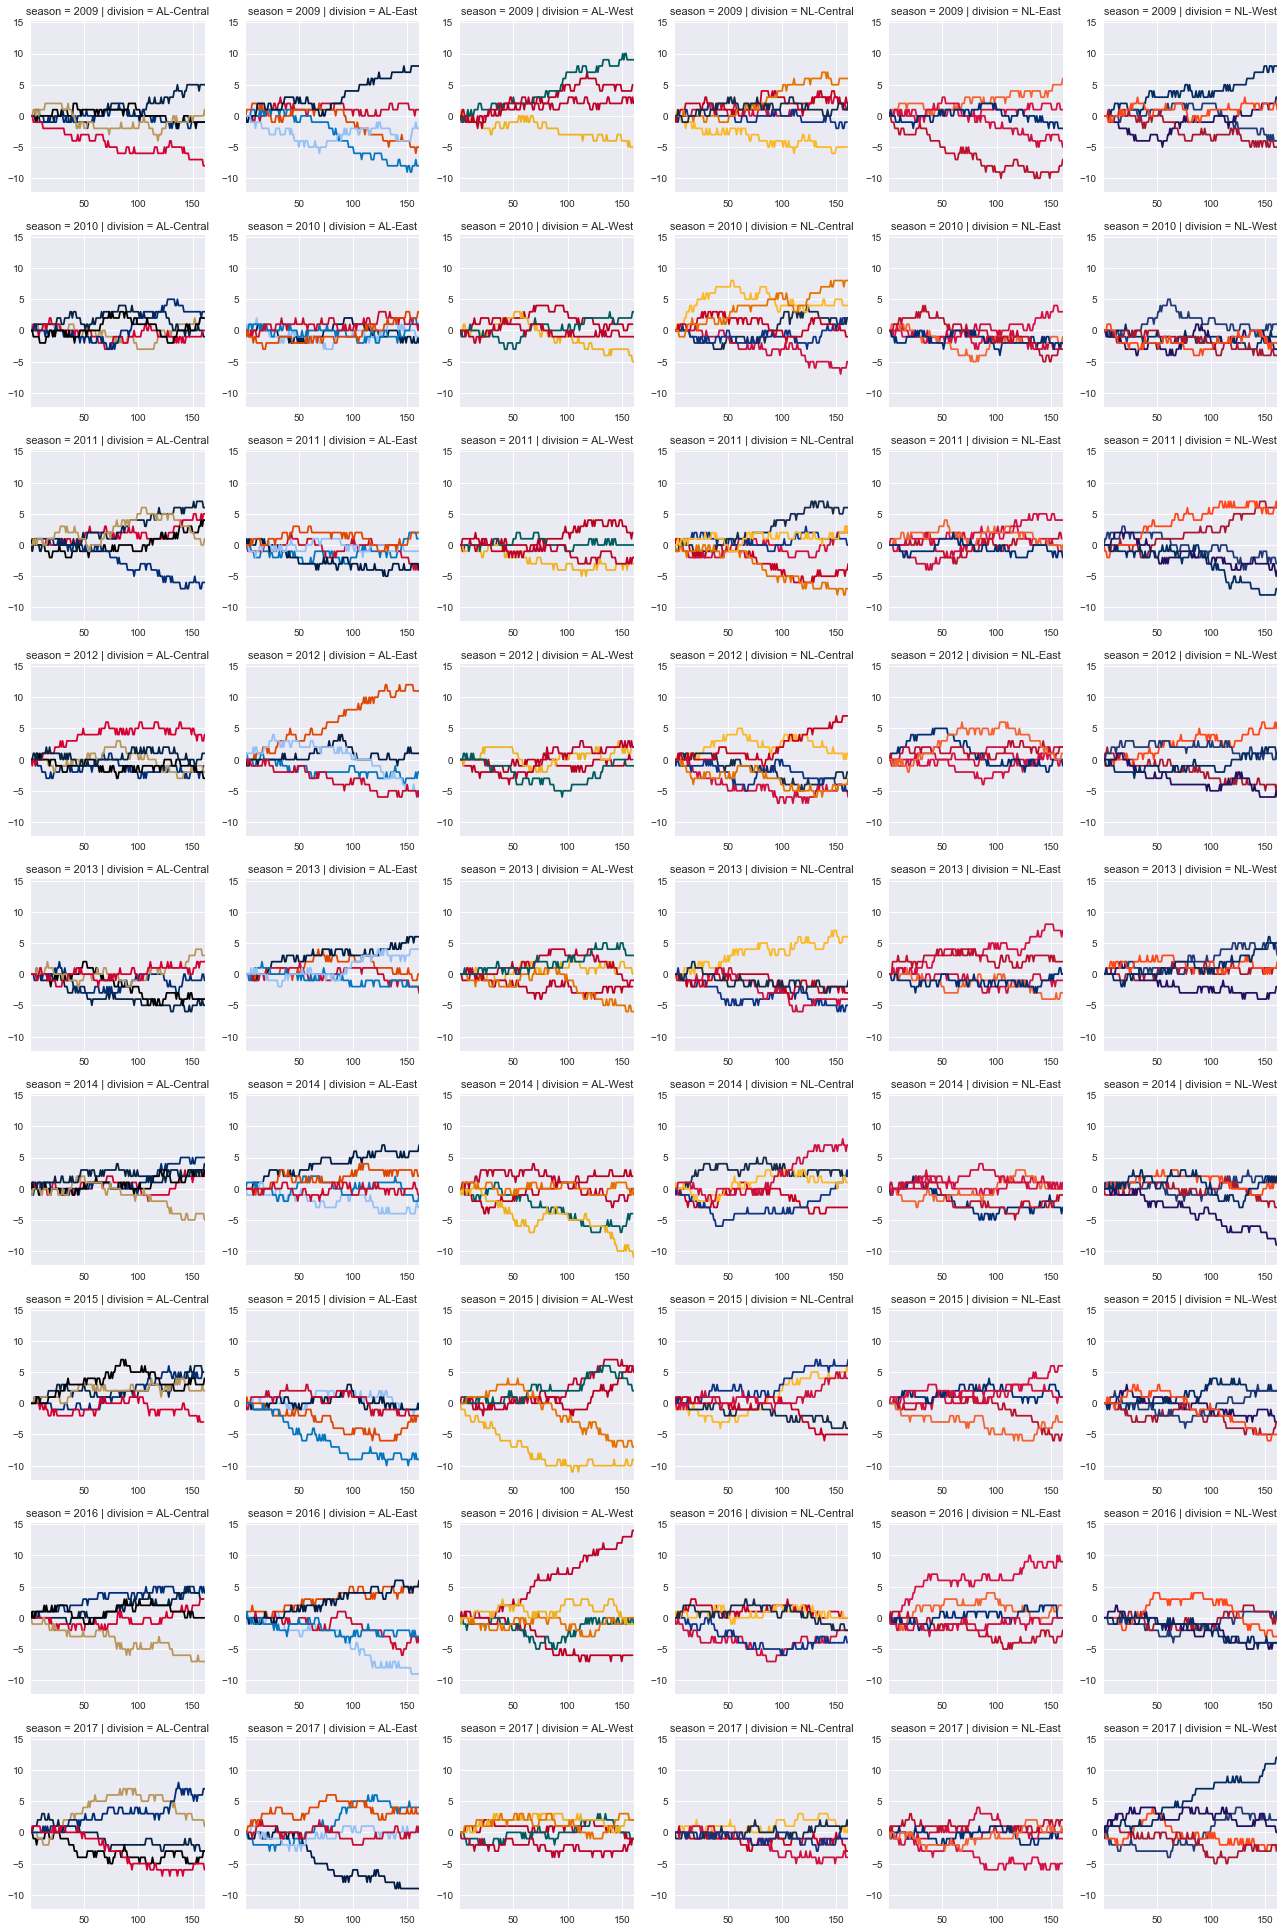

The violin plots below show win difference (compared to the home team) and the respective distributions of home and visitor victories. There isn't much variation from year to year. Immediately, we can see that an advantage in wins does not necessarily suggest a victory. 

The first plot shows overall win difference for each respective team's home and away victories. The second plot shows overall win difference comparing the home team's wins at home with the visiting team's wins on the road.

In [3]:
bball['comp_ldr'] = bball['m_ldr_def'] + bball['m_ldr_off']
bball['comp_gbr'] = bball['m_gbr_def'] + bball['m_gbr_off']
bball['comp_FIP'] = bball['m_xFIP_def'] + bball['m_xFIP_off']
bball['comp_wOBA'] = bball['m_wOBA_def'] + bball['m_wOBA_off']
bball['comp_BABIP'] = bball['m_BABIP_def'] + bball['m_BABIP_off']
bball['comp_kbr'] = bball['m_kbr_def'] + bball['m_kbr_off']

bball['comp_ldr_5'] = bball['m_ldr_def_5'] + bball['m_ldr_off_5']
bball['comp_gbr_5'] = bball['m_gbr_def_5'] + bball['m_gbr_off_5']
bball['comp_FIP_5'] = bball['m_xFIP_def_5'] + bball['m_xFIP_off_5']
bball['comp_wOBA_5'] = bball['m_wOBA_def_5'] + bball['m_wOBA_off_5']
bball['comp_BABIP_5'] = bball['m_BABIP_def_5'] + bball['m_BABIP_off_5']
bball['comp_kbr_5'] = bball['m_kbr_def_5'] + bball['m_kbr_off_5']

bball['comp_ldr_10'] = bball['m_ldr_def_10'] + bball['m_ldr_off_10']
bball['comp_gbr_10'] = bball['m_gbr_def_10'] + bball['m_gbr_off_10']
bball['comp_FIP_10'] = bball['m_xFIP_def_10'] + bball['m_xFIP_off_10']
bball['comp_wOBA_10'] = bball['m_wOBA_def_10'] + bball['m_wOBA_off_10']
bball['comp_BABIP_10'] = bball['m_BABIP_def_10'] + bball['m_BABIP_off_10']
bball['comp_kbr_10'] = bball['m_kbr_def_10'] + bball['m_kbr_off_10']

C:\Users\mendo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mendo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mendo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

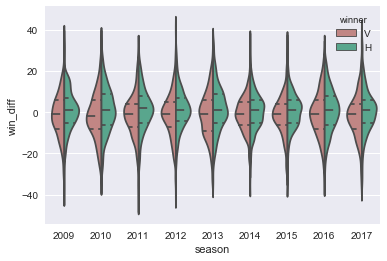

In [4]:
win_comp = bball[['season', 'home_team', 'home_win_c', 'home_r_wins', 'visiting_team_x', 'vis_win_c', 'vis_r_wins', 'winner']]
win_comp['home_win_at_home_perc'] = win_comp['home_win_c']/win_comp['home_r_wins']
win_comp['vis_win_away_perc'] = win_comp['vis_win_c']/win_comp['vis_r_wins']
win_comp['home_perc_diff'] = (win_comp['home_win_at_home_perc'] - win_comp['vis_win_away_perc']).round(3)
win_comp['win_diff'] =  win_comp['home_r_wins'] - win_comp['vis_r_wins']
win_comp['win_diff1'] = win_comp['home_win_c'] - win_comp['vis_win_c']

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.violinplot(x="season", y="win_diff", hue="winner", data=win_comp, split=True,
               inner="quart", palette={"H": "#4CB391", "V": "#cb7c7a"})
plt.show()

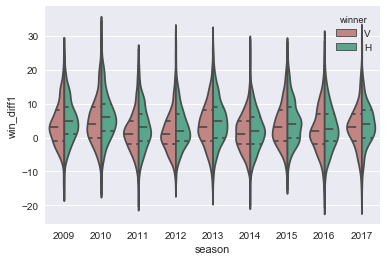

In [5]:
sns.violinplot(x="season", y="win_diff1", hue="winner", data=win_comp, split=True,
               inner="quart", palette={"H": "#4CB391", "V": "#cb7c7a"})
sns.despine(left=True)
plt.show()

Now, let's observe how often the overs occur, how often the home team wins, and how often the betting favorite wins.

In [6]:
bball['pyth_ratio_home'] = bball['home_p_win_percentage_x']/bball['vis_p_win_percentage_x']
bball['pyth_ratio_vis'] = bball['vis_p_win_percentage_x']/bball['home_p_win_percentage_x']

bball['total_win_ratio'] = bball['home_win_percentage']/bball['vis_win_percentage']


winner = []
for row in bball['winner']:
    if row=='H':
        winner.append(1)
    else:
        winner.append(0)
bball['home_win'] = winner

bball['total_runs'] = bball['home_final'] + bball['vis_final']

favorite = []
fav_team = []
for index, row in bball.iterrows():
    if row['p_ml_home_final'] < row['p_ml_away_final']:
        favorite.append(1)
        fav_team.append(row['home_team'])
    else:
        favorite.append(0)
        fav_team.append(row['visiting_team_x'])
bball['favorite'] = favorite
bball['fav_team'] = fav_team

In [7]:
fav_win = []        
for index, row in bball.iterrows():       
    if row['fav_team']==row['winning_team']:
        fav_win.append(1)
    else:
        fav_win.append(0)
bball['fav_win'] = fav_win

ou6 = []
ou7 = []
ou8 = []
for row in bball['total_runs']:
    if row > 8:
        ou6.append(1)
        ou7.append(1)
        ou8.append(1)
    elif row > 7:
        ou6.append(1)
        ou7.append(1)
        ou8.append(0)
    elif row > 6:
        ou6.append(1)
        ou7.append(0)
        ou8.append(0)
    else:
        ou6.append(0)
        ou7.append(0)
        ou8.append(0)
bball['ou6'] = ou6
bball['ou7'] = ou7
bball['ou8'] = ou8

In [8]:
htw = (bball['home_win'].sum()/len(bball['home_win'])*100)
bf = bball['fav_win'].sum()/len(bball['fav_win'])*100
o6 = bball['ou6'].sum()/len(bball['ou6'])*100
o7 = bball['ou7'].sum()/len(bball['ou7'])*100
o8 = bball['ou8'].sum()/len(bball['ou8'])*100

print('Home Team Win:', htw, '%')
print('Betting Favorite Win :', bf, '%')

print('Over 6 :', o6, '%')
print('Over 7 :', o7, '%')
print('Over 8 :', o8, '%')

Home Team Win: 54.11401291771975 %
Betting Favorite Win : 57.82785734344286 %
Over 6 : 66.2945801741084 %
Over 7 : 54.99859590002808 %
Over 8 : 47.06543105869138 %


The correlation plot below begins to investigtate the connection between the winner (Home or Away), their win percentage, and the odds. No correlation is particularly strong; however, there are some interesting trends. 

A higher temperature is associated with a higher run total for both teams--this supports the theory that the ball travels farther in hotter air, no surprise there.

There's a negative correlation between a visiting team's win percentage and the number of runs the home team scores and a positive correlation with their own number of runs. In short: better teams typically score more and allow fewer runs. This is in no way groundbreaking, but what is notable, though, is the relatively weak correlation between those variables. 

A better team often loses--teams with over 100 wins are exceptional, but even they lose close to forty percent of the time. What are the conditions that point to an upset? These are the games with more favorable odds and, not coincidentally, are harder to predict.

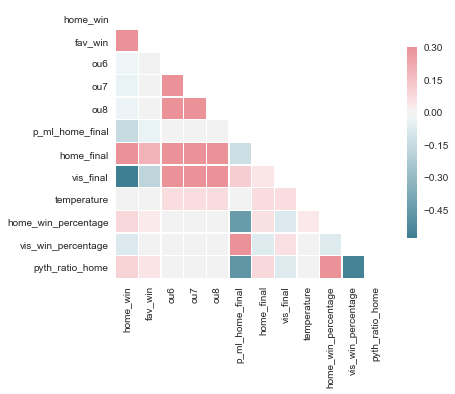

In [9]:
df1 = bball[['home_win', 'fav_win', 'ou6', 'ou7', 'ou8', 'p_ml_home_final', 'home_final', 
             'vis_final', 'temperature',
            'home_win_percentage', 'vis_win_percentage', 'pyth_ratio_home']]


corr1 = df1.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

Now, we're going to dive in to the calculated features. 

All of the calculated stats compare the away team to the home team. 'ldr_def' compares the average of the home starting pitcher and bullpen to the visiting team's batting numbers. 'ldr_off' compares the home team's batting to the the mean of the visiting team's starting pitcher and bullpen. In this way, we can observe pitching versus hitting matchups. A negative def stat implies an advantage for the visiting team and vise versa.

LDR: linedrive rate

GBR: grounball rate

FIP: Fielding Independent Pitching

wOBA: Weighted On Base Average

BABIP: Batting Average on Balls in Play

KBR: strikeout to walk ratio

Each of these has a comparison for the cumulative average and comparisons for the last five and ten games respectively. If the better team doesn't always win, perhaps their recent performance can illuminate some of the reasons for those losses.

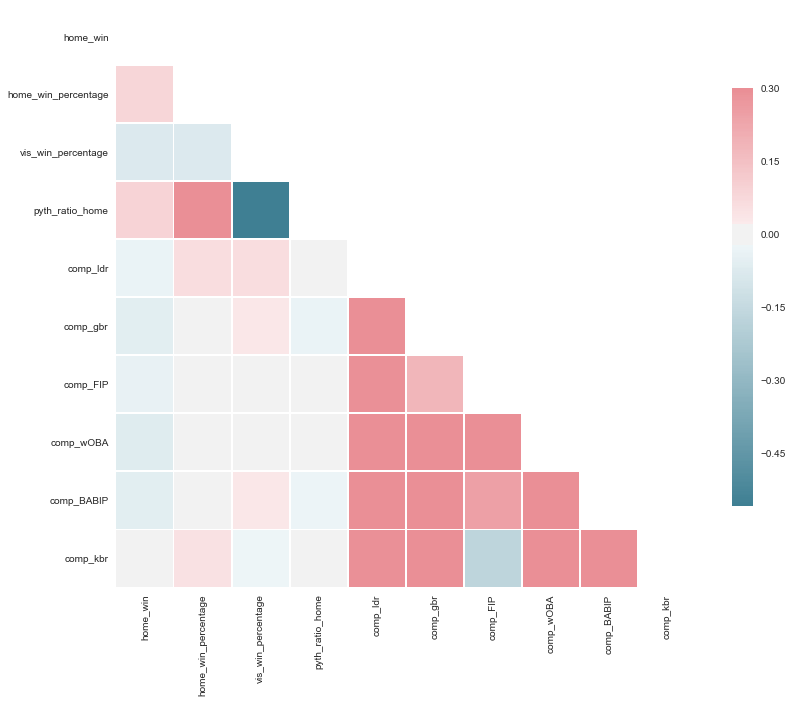

In [10]:
df = bball[['home_win', 'home_win_percentage', 'vis_win_percentage', 'pyth_ratio_home',
            'comp_ldr','comp_gbr', 'comp_FIP', 'comp_wOBA', 'comp_BABIP', 'comp_kbr']]

corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
f, ax = plt.subplots(figsize=(13, 11))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

First, let's look at the cumulative measures and compare them to the winner and the over/unders.

A positive pyth ratio for the home team corresponds to a home win--if not nsightful, it's a good gut check. In that same vein, a better LDR rate is associated with a higher win percentage--they're making better contact with the ball.

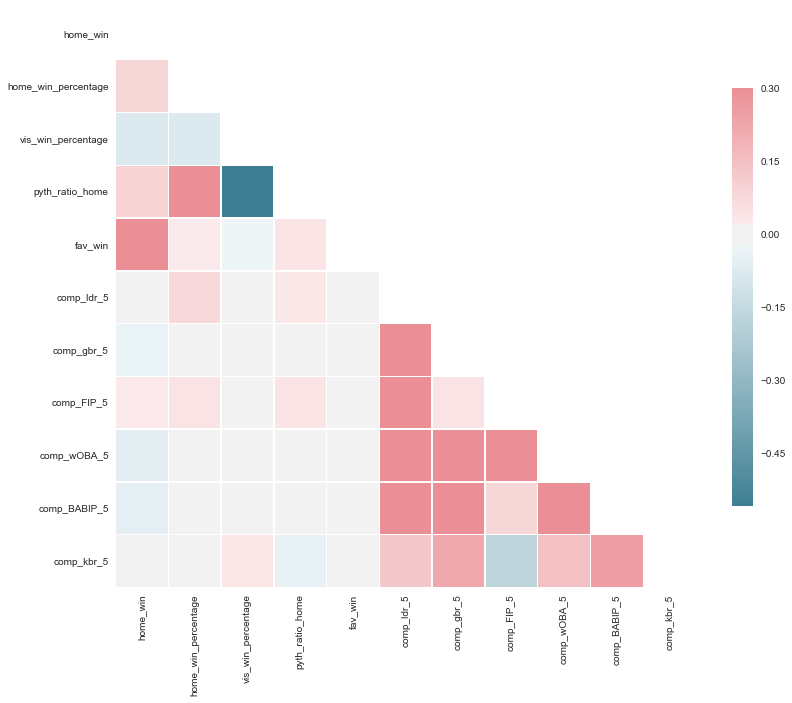

In [11]:
df = bball[['home_win','home_win_percentage', 'vis_win_percentage', 'pyth_ratio_home',
            'fav_win', 'comp_ldr_5', 'comp_gbr_5', 'comp_FIP_5', 'comp_wOBA_5',
       'comp_BABIP_5', 'comp_kbr_5']]

corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
f, ax = plt.subplots(figsize=(13, 11))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

Now, we'll look at the five game streaks. There are two interesting items to point out. First, and most surprisingly, if a home team has a higher defensive FIP (their pitching is worse than the batters they're about to face, roughly speaking), they are actually slightly more likely to win.

Another good gut check: the better the strikeout-walk ratio, the lower the FIP over five games.

The plot for the ten game streak looks very similar to the cumulative plot. Streaks must be important, but stat differences are pretty much average over ten games.

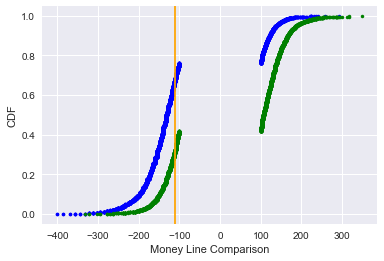

In [12]:
h_win = bball[bball['winner']=='H']
v_win = bball[bball['winner']=='V']

import numpy as np

def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    return x,y

s_x, s_y = ecdf(h_win['p_ml_home_final'])
b_x, b_y = ecdf(v_win['p_ml_away_final'])


sns.set()
q1 = plt.plot(s_x, s_y, marker='.', color='blue', linestyle='none')
q1 = plt.plot(b_x, b_y, marker='.', color='green', linestyle='none')
plt.axvline(x=-110, color='orange')

plt.xlabel('Money Line Comparison')
plt.ylabel('CDF')
plt.show()

The orange line represents an even line, meaning each team costs the same to bet on--anything to the right of the line is considered an 'underdog' line.

Around 65% of home wins were also betting favorites and around 65% of away wins were underdogs--interesting symmetry. This is the beginning of an approach that searches for 'value bets.' When are the odds skewed one way or the other? And therefore, are there times that the calculated fields identify odds that don't properly value teams?

That may mean picking a team that is unlikely to win, but cheaper to put money on given their performance. A great initial target would be visiting teams with a favorable pyth_ratio and positive odds. Vegas, in these cases, would be overvaluing home field advantage relative to performance.

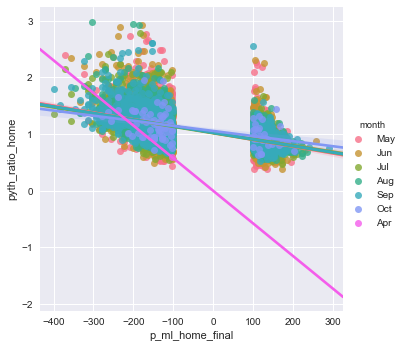

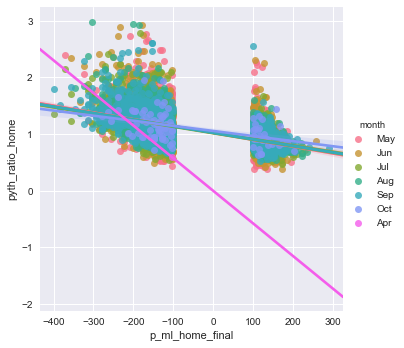

In [13]:
sns.lmplot(data=h_win, x='p_ml_home_final', y='pyth_ratio_home', hue='month')
sns.lmplot(data=h_win, x='p_ml_home_final', y='pyth_ratio_home', hue='month')
plt.show()

The scatter plots above show the pyth_ratio and betting lines condense as the season goes on--the more information available, the tighter the spreads get.

## Inferential Statistics

In [14]:
h_win = h_win.fillna(0)
v_win = v_win.fillna(0)

h_win = h_win[h_win['home_s_pitcher']!=0]
v_win = v_win[v_win['home_s_pitcher']!=0]


Next, let's compare each of our calculated fields for home and vistor wins. 

I've separated the data into two: home wins and visitor wins. I want to see if there is a significant difference between each calculated stat for a home team and its counterpart for the visiting team for each respective win type.

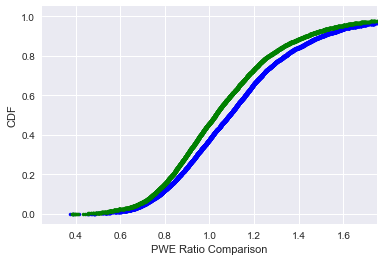

In [15]:
s_x, s_y = ecdf(h_win['pyth_ratio_home'])
b_x, b_y = ecdf(v_win['pyth_ratio_home'])


sns.set()
q1 = plt.plot(s_x, s_y, marker='.', color='blue', linestyle='none')
q1 = plt.plot(b_x, b_y, marker='.', color='green', linestyle='none')
plt.xlim(.25,1.75)
plt.xlabel('PWE Ratio Comparison')
plt.ylabel('CDF')
plt.show()

It appears that the PWE Ratio is different for home and away victories, so now I'll look at a series of two-sample z-tests for my features.

First, I'll take a look at the summary statistics and do a quick eye check to spot any differences, especially in the mean and standard deviation.

In [16]:
h_win[['comp_ldr','comp_gbr', 'comp_FIP', 'comp_wOBA', 'comp_BABIP', 'comp_kbr',
       'comp_ldr_5', 'comp_gbr_5', 'comp_FIP_5', 'comp_wOBA_5',
       'comp_BABIP_5', 'comp_kbr_5', 'comp_ldr_10', 'comp_gbr_10',
       'comp_FIP_10', 'comp_wOBA_10', 'comp_BABIP_10', 'comp_kbr_10',
       'pyth_ratio_home', 'pyth_ratio_vis']].describe()

,comp_ldr,comp_gbr,comp_FIP,comp_wOBA,comp_BABIP,comp_kbr,comp_ldr_5,comp_gbr_5,comp_FIP_5,comp_wOBA_5,comp_BABIP_5,comp_kbr_5,comp_ldr_10,comp_gbr_10,comp_FIP_10,comp_wOBA_10,comp_BABIP_10,comp_kbr_10,pyth_ratio_home,pyth_ratio_vis
count,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000,7388.000000
mean,0.049005,0.014479,0.033661,0.009217,0.007853,0.106962,0.000952,0.016936,0.163184,0.008641,0.006256,0.010126,0.002133,0.018392,0.045447,0.009778,0.009243,0.089451,1.123357,0.953532
std,0.097968,0.137353,1.023482,0.087582,0.079581,1.406327,0.135892,0.172980,2.406725,0.113480,0.108813,4.046855,0.109122,0.173414,1.437962,0.110958,0.103141,2.887714,0.304663,0.253300
min,-0.857981,-0.378434,-12.488032,-0.222591,-0.215557,-15.047831,-0.892798,-0.505553,-44.355180,-0.359283,-0.358979,-29.346459,-0.479287,-0.464003,-5.083276,-0.303031,-0.266963,-25.290466,0.375627,0.336394
25%,-0.003905,-0.042424,-0.595481,-0.025047,-0.025386,-0.636394,-0.081092,-0.076981,-1.281128,-0.053644,-0.058273,-2.000035,-0.063803,-0.069805,-0.926927,-0.046776,-0.048386,-1.210408,0.909774,0.780165
50%,0.054198,0.001124,0.019049,-0.000049,0.000536,0.056283,-0.000048,0.003724,0.127689,-0.000141,-0.001168,-0.011724,-0.000483,0.003873,0.075942,0.000553,0.001778,0.072575,1.089829,0.917575
75%,0.104835,0.043954,0.627394,0.025960,0.026469,0.742771,0.080526,0.086423,1.541547,0.056726,0.057860,1.985341,0.063026,0.081672,1.028613,0.050857,0.054151,1.381076,1.281779,1.099174
max,0.494184,1.090041,12.195631,0.604588,0.533493,11.206981,0.680813,1.151628,42.130225,0.675093,0.653226,25.606061,0.655971,1.085332,6.418430,0.636024,0.588299,22.146444,2.972701,2.662213


In [17]:
v_win[['comp_ldr','comp_gbr', 'comp_FIP', 'comp_wOBA', 'comp_BABIP', 'comp_kbr',
       'comp_ldr_5', 'comp_gbr_5', 'comp_FIP_5', 'comp_wOBA_5',
       'comp_BABIP_5', 'comp_kbr_5', 'comp_ldr_10', 'comp_gbr_10',
       'comp_FIP_10', 'comp_wOBA_10', 'comp_BABIP_10', 'comp_kbr_10',
       'pyth_ratio_home', 'pyth_ratio_vis']].describe()

,comp_ldr,comp_gbr,comp_FIP,comp_wOBA,comp_BABIP,comp_kbr,comp_ldr_5,comp_gbr_5,comp_FIP_5,comp_wOBA_5,comp_BABIP_5,comp_kbr_5,comp_ldr_10,comp_gbr_10,comp_FIP_10,comp_wOBA_10,comp_BABIP_10,comp_kbr_10,pyth_ratio_home,pyth_ratio_vis
count,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000
mean,0.055613,0.034331,0.119338,0.022720,0.019101,0.129727,0.005362,0.031673,0.026801,0.022405,0.018616,0.071626,0.004219,0.029168,0.036205,0.018545,0.016377,0.085722,1.066503,1.004240
std,0.106130,0.190434,1.021507,0.116653,0.105321,1.633424,0.143233,0.216366,2.578152,0.137601,0.129031,4.147552,0.119029,0.214877,1.415674,0.135061,0.123944,2.938592,0.288464,0.268665
min,-0.994338,-0.364617,-6.882076,-0.290568,-0.223911,-16.607907,-0.766534,-0.529971,-49.339212,-0.481867,-0.389774,-45.511218,-0.531962,-0.476193,-5.457166,-0.341830,-0.296901,-23.989214,0.383856,0.343144
25%,-0.001692,-0.042292,-0.507740,-0.021609,-0.023232,-0.708536,-0.082590,-0.080445,-1.310040,-0.052061,-0.055216,-1.966914,-0.069226,-0.076050,-0.934499,-0.046984,-0.049064,-1.308095,0.867878,0.821958
50%,0.056293,0.003490,0.096260,0.004085,0.002741,-0.021121,-0.001063,0.004239,0.045381,0.006810,0.003855,-0.002753,-0.002311,0.003263,0.034553,0.004467,0.003682,0.020833,1.026561,0.974126
75%,0.109152,0.048680,0.730301,0.030763,0.029331,0.713375,0.086510,0.091495,1.421618,0.065507,0.066958,2.124375,0.062467,0.080643,0.981651,0.054544,0.055787,1.321560,1.216607,1.152236
max,0.530753,1.068937,8.770598,0.640269,0.560721,20.147822,0.709955,1.192641,53.714125,0.759940,0.707879,19.843056,0.577765,1.092027,5.610449,0.700568,0.657173,23.910962,2.914231,2.605147


Because I'm comparing two different outcomes--with different means and standard deviations--I'll use ztest_ind() with usevar='unequal'. 

Null Hypotheses: there is no difference between the mean for variable-n for home victories and away victories.

In [18]:
import scipy.stats as stats
from statsmodels.stats.weightstats import CompareMeans


test2 = CompareMeans.from_data(h_win['pyth_ratio_home'], v_win['pyth_ratio_home']).ztest_ind(usevar='unequal')
print('PWE Ratio Z-Test:', test2)

print()

test3 = CompareMeans.from_data(h_win['comp_ldr'], v_win['comp_ldr']).ztest_ind(usevar='unequal')
print('LDR Z-Test:', test3)

test4 = CompareMeans.from_data(h_win['comp_FIP'], v_win['comp_FIP']).ztest_ind(usevar='unequal')
print('FIP Z-Test:', test4)

test5 = CompareMeans.from_data(h_win['comp_BABIP'], v_win['comp_BABIP']).ztest_ind(usevar='unequal')
print('BABIP Z-Test:', test5)

test6 = CompareMeans.from_data(h_win['comp_wOBA'], v_win['comp_wOBA']).ztest_ind(usevar='unequal')
print('wOBA Z-Test:', test6)

print()


test7 = CompareMeans.from_data(h_win['comp_ldr_5'], v_win['comp_ldr_5']).ztest_ind(usevar='unequal')
print('LDR 5 Z-Test:', test7)

test8 = CompareMeans.from_data(h_win['comp_FIP_5'], v_win['comp_FIP_5']).ztest_ind(usevar='unequal')
print('FIP 5 Z-Test:', test8)

test9 = CompareMeans.from_data(h_win['comp_BABIP_5'], v_win['comp_BABIP_5']).ztest_ind(usevar='unequal')
print('BABIP 5 Z-Test:', test9)

test10 = CompareMeans.from_data(h_win['comp_wOBA_5'], v_win['comp_wOBA_5']).ztest_ind(usevar='unequal')
print('wOBA 5 Z-Test:', test10)

print()

test11 = CompareMeans.from_data(h_win['comp_ldr_10'], v_win['comp_ldr_10']).ztest_ind(usevar='unequal')
print('LDR 10 Z-Test:', test11)

test12 = CompareMeans.from_data(h_win['comp_FIP_10'], v_win['comp_FIP_10']).ztest_ind(usevar='unequal')
print('FIP 10 Z-Test:', test12)

test13 = CompareMeans.from_data(h_win['comp_BABIP_10'], v_win['comp_BABIP_10']).ztest_ind(usevar='unequal')
print('BABIP 10 Z-Test:', test13)

test14 = CompareMeans.from_data(h_win['comp_wOBA_10'], v_win['comp_wOBA_10']).ztest_ind(usevar='unequal')
print('wOBA 10 Z-Test:', test14)

print()

PWE Ratio Z-Test: (11.295174311402373, 1.3862873505520657e-29)

LDR Z-Test: (-3.7974103873220773, 0.00014621560926132034)
FIP Z-Test: (-4.93056770747872, 8.1990992248931989e-07)
BABIP Z-Test: (-7.0305295329663968, 2.0575116705338135e-12)
wOBA Z-Test: (-7.6359837647260953, 2.2410256418892976e-14)

LDR 5 Z-Test: (-1.8556490099491483, 0.063503603138505227)
FIP 5 Z-Test: (3.2107735318392967, 0.0013237821549276353)
BABIP 5 Z-Test: (-6.0610937966242782, 1.3519895678949115e-09)
wOBA 5 Z-Test: (-6.3835241614079195, 1.7305827573680148e-10)

LDR 10 Z-Test: (-1.0720218180798489, 0.2837102325165628)
FIP 10 Z-Test: (0.38132169924859793, 0.70296455416759041)
BABIP 10 Z-Test: (-3.6604430209000709, 0.00025177954117969491)
wOBA 10 Z-Test: (-4.1481736079956253, 3.3513822067060504e-05)



A lot of these z-tests have significant values that allow us to reject the null hypothesis. It makes sense that home teams that win have a higher pyth_ratio, but the others are harder to reconcile.

Nearly every other z-score implies that an advantage is lower for a home win and higher for a visiting win. An interesting exception is the z-score for FIP and FIP_5. The value is negative for FIP (meaning home wins correspond to a lower FIP), but positive for FIP_5 (meaning home wins correspond to a higher FIP_5).

### Going Forward

At this point, I think it will be useful to unravel some of these comparison and look at the raw calculations as well. This will also go far in illuminating patterns for the over/under bets, which should be more straightforward than looking for a win. It may also be useful to separate out the bullpen and starting pitchers instead of averaging them with each other.

After making these adjustments and performing more statistical analysis, I'll move on to the machine learning portion.

I'll perform a logistic regression for the win/loss and over/under and a linear regression to inform create some confidence level to adjust the size of a wager.